In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

from pytorch_lightning.strategies import DDPStrategy

from paper_utils import LightningResNet18

import configparser
from paper_utils import PoincareDataModule

In [9]:
isBool = lambda x: x.lower() == "true"
converters = {
    "IntList": lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(",")],
    "FloatList": lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(",")],
    "BoolList": lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(",")],
}
config = configparser.ConfigParser(converters=converters)

In [10]:
# analyse results resulting from running `SAM_train_model.py` using config = SAM_study.cfg
config_file = Path("./configs/model_training/SAM_study.cfg")
config.read(config_file)

# read the study parameters from the config file

# LOGGING params
# -------------------------------------------------------
log_dir = config.get("LOGGING", "log_dir")
name = config.get("LOGGING", "name")
# -------------------------------------------------------
# HARDWARE params
# -------------------------------------------------------
num_workers = config.getint("HARDWARE", "num_workers")
auto_select_gpus = config.getboolean("HARDWARE", "auto_select_gpus")
num_gpus = config.getint("HARDWARE", "num_gpus")

if auto_select_gpus == True:
    devices = num_gpus
else:
    devices = config.getIntList("HARDWARE", "devices")
if devices > 1:
    num_workers = 0
    strategy = DDPStrategy(find_unused_parameters=False)
else:
    num_workers = num_workers
    strategy = None
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
data_dir = config.get("DATAMODULE", "data_dir")
main_lookup_dir = config.get("DATAMODULE", "main_lookup_dir")
local_lookup_dir = config.get("DATAMODULE", "local_lookup_dir")
batch_size = config.getint("DATAMODULE", "batch_size")
img_widths = config.getIntList("DATAMODULE", "img_width")
alpha = config.getfloat("DATAMODULE", "alpha")
min_samples = config.getint("DATAMODULE", "min_samples", fallback=0)
max_samples = config.getint("DATAMODULE", "max_samples", fallback=-1)
min_traj_len = config.getint("DATAMODULE", "min_traj_len")
max_traj_len = config.getint("DATAMODULE", "max_traj_len")
num_params = config.getint("DATAMODULE", "num_params")
if ("param_min" in config["DATAMODULE"]) or ("param_max" in config["DATAMODULE"]):
    if not (
        ("param_min" in config["DATAMODULE"]) and ("param_max" in config["DATAMODULE"])
    ):
        raise ValueError("Must specify both param_min and param_max, or neither")
    else:
        param_min = np.array(config.getFloatList("DATAMODULE", "param_min"))
        param_max = np.array(config.getFloatList("DATAMODULE", "param_max"))
        assert num_params == len(param_min) == len(param_max)
else:
    param_min = None
    param_max = None

coords = config.getIntList("DATAMODULE", "coords", fallback=[0, 1])
print(f"{coords=}")
x_range = config.getFloatList("DATAMODULE", "x_range", fallback=None)
y_range = config.getFloatList("DATAMODULE", "y_range", fallback=None)

coords=[0, 2]


In [11]:
trainer = pl.Trainer(
    logger=False,
    accelerator="gpu",
    devices=devices,
    num_sanity_val_steps=0,
    deterministic=True,
    auto_select_gpus=auto_select_gpus,
    enable_progress_bar=False,
)

assert len(img_widths) == 1

sample_frac = 1.0
np.random.seed(42)
torch.manual_seed(42)
aug_datamodule = PoincareDataModule(
    local_lookup_dir=local_lookup_dir,
    data_dir=data_dir,
    coords=coords,
    sample_frac=sample_frac,
    img_width=img_widths[0],
    batch_size=batch_size,
    x_range=x_range,
    y_range=y_range,
    alpha=alpha,
    min_samples=min_samples,
    max_samples=max_samples,
    min_traj_len=min_traj_len,
    max_traj_len=max_traj_len,
    num_workers=num_workers,
    verbose=True,
    randomize=True,
)

np.random.seed(42)
torch.manual_seed(42)
non_aug_datamodule = PoincareDataModule(
    local_lookup_dir=local_lookup_dir,
    data_dir=data_dir,
    coords=coords,
    sample_frac=sample_frac,
    img_width=img_widths[0],
    batch_size=batch_size,
    x_range=x_range,
    y_range=y_range,
    alpha=alpha,
    min_samples=min_samples,
    max_samples=max_samples,
    min_traj_len=min_traj_len,
    max_traj_len=max_traj_len,
    num_workers=num_workers,
    verbose=True,
    randomize=False,
)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


In [12]:
# this code iterates through the model directories, loads the YAML file, iterates through the model checkpoints,
# loads the model, tests the model, and adds the loss, number of training images, and whether the model was
# trained with augmentation to a DataFrame

df_list = []
p = Path(log_dir)

# iterate through the model directories
for i in p.rglob("*version_0/"):
    print(i.parent.name)  # get the name of the parent directory

    # load the YAML file
    hparam_dict = yaml.load(open(i / "hparams.yaml"), yaml.FullLoader)
    num_train = hparam_dict["num_train"]
    randomized = hparam_dict["randomize"]
    print(f"{num_train=}, {randomized=}")

    # iterate through the model checkpoints
    for child in i.parent.iterdir():
        if child.is_dir():
            for j in child.iterdir():
                if j.is_dir():
                    for model_ckpt in j.iterdir():
                        print(
                            f"{model_ckpt.name=}"
                        )  # get the name of the checkpoint file

                        # load the model
                        model = LightningResNet18.load_from_checkpoint(
                            model_ckpt.resolve()
                        )
                        datamodule = (
                            aug_datamodule if randomized else non_aug_datamodule
                        )

                        # test the model
                        test_loss = trainer.test(
                            model=model,
                            datamodule=datamodule,
                            verbose=False,
                        )[0]["val_mse"]
                        df_list.append(
                            {
                                "loss": test_loss,
                                "num_train": num_train,
                                "Train Augmentation": randomized,
                            }
                        )
SAM_df = pd.DataFrame(df_list)

SAM__sample_frac_1.00
num_train=7680, randomized=False
model_ckpt.name='epoch=97-val_mse=2.19e-03_randomized_False.ckpt'


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=99-val_mse=2.63e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=86-val_mse=2.56e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_1.00
num_train=7680, randomized=True
model_ckpt.name='epoch=103-val_mse=4.35e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=103-val_mse=5.34e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=100-val_mse=5.60e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.50
num_train=3840, randomized=False
model_ckpt.name='epoch=160-val_mse=3.74e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=191-val_mse=4.02e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=187-val_mse=4.60e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.50
num_train=3840, randomized=True
model_ckpt.name='epoch=203-val_mse=5.11e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=207-val_mse=5.22e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=196-val_mse=5.72e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.25
num_train=1920, randomized=False
model_ckpt.name='epoch=411-val_mse=5.23e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=411-val_mse=5.75e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=415-val_mse=5.08e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.25
num_train=1920, randomized=True
model_ckpt.name='epoch=376-val_mse=4.16e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=408-val_mse=4.52e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=407-val_mse=5.66e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.06
num_train=480, randomized=False
model_ckpt.name='epoch=754-val_mse=2.63e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1661-val_mse=2.17e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1635-val_mse=1.77e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.06
num_train=480, randomized=True
model_ckpt.name='epoch=1657-val_mse=5.05e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1209-val_mse=4.50e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=966-val_mse=5.63e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.02
num_train=120, randomized=False
model_ckpt.name='epoch=1921-val_mse=3.66e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3160-val_mse=1.57e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=4417-val_mse=9.89e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.02
num_train=120, randomized=True
model_ckpt.name='epoch=5439-val_mse=3.05e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5693-val_mse=4.72e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5268-val_mse=3.73e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.03
num_train=240, randomized=False
model_ckpt.name='epoch=2212-val_mse=9.17e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2851-val_mse=2.39e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2788-val_mse=9.53e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.03
num_train=240, randomized=True
model_ckpt.name='epoch=2772-val_mse=6.46e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2836-val_mse=7.91e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3048-val_mse=6.50e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.12
num_train=960, randomized=False
model_ckpt.name='epoch=809-val_mse=5.87e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=436-val_mse=8.26e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=777-val_mse=6.55e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.12
num_train=960, randomized=True
model_ckpt.name='epoch=716-val_mse=4.47e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=826-val_mse=3.76e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=814-val_mse=5.90e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


In [15]:
import seaborn as sns

LINE_PLOT_BLACK = ".2"
BAR_PLOT_ORANGE = (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0)
LINE_PLOT_ORANGE = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
HATCH = "/"

sns.set_theme(context="paper", style="ticks", font_scale=1.75)


# update line plot markers
def fix_lineplot_markers(plot):
    for line in plot.get_lines():
        if line.get_color() == LINE_PLOT_BLACK:
            line.set_marker("")
        else:
            line.set_marker("o")
            line.set_markeredgecolor("k")
            line.set_markersize(10)
            if line.get_color() == LINE_PLOT_ORANGE:
                line.set_marker("D")


# update barplot patches
def fix_barplot_patches(plot):
    for thisbar in plot.patches:
        thisbar.set_edgecolor("k")
        if thisbar._facecolor == BAR_PLOT_ORANGE:
            thisbar.set_hatch(HATCH)

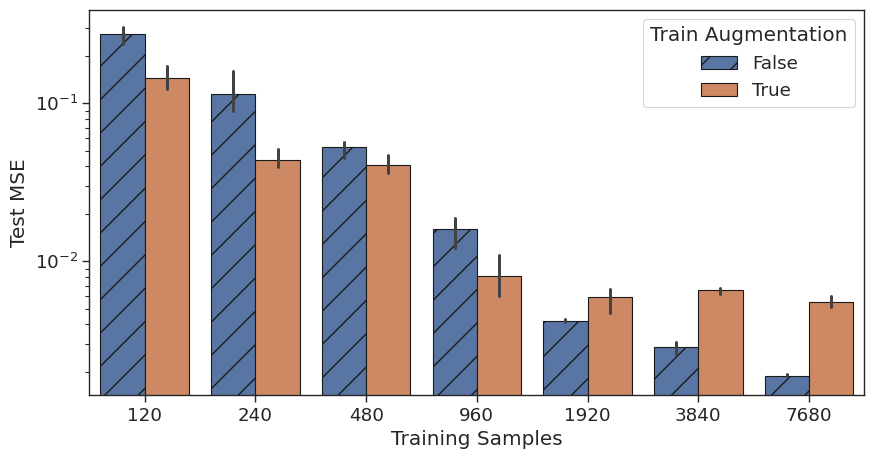

In [17]:
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_yscale("log")
# df = pd.read_csv("sample_efficiency_trials.csv")
plot = sns.barplot(data=SAM_df, x="num_train", y="loss", hue="Train Augmentation")

fix_barplot_patches(plot)
ax.set_yscale("log")
ax.set_xlabel("Training Samples")
ax.set_ylabel("Test MSE")
ax.legend(title="Train Augmentation", loc="upper right")

plt.savefig("SAM_bargraph.pdf", bbox_inches="tight")

In [9]:
augmented_models = []
non_augmented_models = []

p = Path(log_dir)
for i in p.rglob("*SAM__sample_frac_1.00/"):
    print(i.name)
    if i.is_dir():
        for child in i.rglob("*.ckpt"):
            print(child.name)
            if (child.name.strip(".ckpt").split("_")[-1]) == "True":
                augmented_models.append(
                    LightningResNet18().load_from_checkpoint(child.resolve())
                )
            else:
                non_augmented_models.append(
                    LightningResNet18().load_from_checkpoint(child.resolve())
                )

SAM__sample_frac_1.00
epoch=97-val_mse=2.19e-03_randomized_False.ckpt


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch=99-val_mse=2.63e-03_randomized_False.ckpt
epoch=86-val_mse=2.56e-03_randomized_False.ckpt
SAM__sample_frac_1.00
epoch=103-val_mse=4.35e-03_randomized_True.ckpt
epoch=103-val_mse=5.34e-03_randomized_True.ckpt
epoch=100-val_mse=5.60e-03_randomized_True.ckpt


In [10]:
traj_lengths = [33, 66, 112, 225, 450, 900]

# augmented_models = [LightningResNet18().load_from_checkpoint('/scratch-a/connorsteph/paper_experiments/henon_map/num_samples_10000/img_width_128/randomized_True/num_samples_10000/version_0/checkpoints/epoch=461-val_mse=1.51e-02_randomized_True.ckpt')]
# non_augmented_models = [LightningResNet18().load_from_checkpoint('/scratch-a/connorsteph/paper_experiments/henon_map/num_samples_10000/img_width_128/randomized_False/num_samples_10000/version_0/checkpoints/epoch=380-val_mse=5.18e-03_randomized_False.ckpt')]

df_list = []

sample_frac = 1.0

for t in traj_lengths:
    print(t)
    np.random.seed(42)
    torch.manual_seed(42)
    aug_datamodule = PoincareDataModule(
        local_lookup_dir=local_lookup_dir,
        data_dir=data_dir,
        coords=coords,
        sample_frac=sample_frac,
        img_width=img_widths[0],
        batch_size=batch_size,
        x_range=x_range,
        y_range=y_range,
        alpha=alpha,
        min_samples=min_samples,
        max_samples=max_samples,
        min_traj_len=min_traj_len,
        max_traj_len=t,
        num_workers=num_workers,
        verbose=False,
        randomize=True,
    )
    np.random.seed(42)
    torch.manual_seed(42)
    non_aug_datamodule = PoincareDataModule(
        local_lookup_dir=local_lookup_dir,
        data_dir=data_dir,
        coords=coords,
        sample_frac=sample_frac,
        img_width=img_widths[0],
        batch_size=batch_size,
        x_range=x_range,
        y_range=y_range,
        alpha=alpha,
        min_samples=min_samples,
        max_samples=max_samples,
        min_traj_len=min_traj_len,
        max_traj_len=t,
        num_workers=num_workers,
        verbose=False,
        randomize=False,
    )

    for augmented_model, non_augmented_model in zip(
        augmented_models, non_augmented_models
    ):
        aug_aug_loss = trainer.test(
            model=augmented_model, dataloaders=aug_datamodule, verbose=False
        )[0]["val_mse"]
        aug_non_loss = trainer.test(
            model=augmented_model, dataloaders=non_aug_datamodule, verbose=False
        )[0]["val_mse"]
        non_aug_loss = trainer.test(
            model=non_augmented_model, dataloaders=aug_datamodule, verbose=False
        )[0]["val_mse"]
        non_non_loss = trainer.test(
            model=non_augmented_model, dataloaders=non_aug_datamodule, verbose=False
        )[0]["val_mse"]
        print(f"{aug_aug_loss=}, {aug_non_loss=}, {non_aug_loss=}, {non_non_loss=}")
        df_list.append(
            {
                "traj_len": t,
                "Training Augmentation": True,
                "Testing Augmentation": True,
                "Loss": aug_aug_loss,
            }
        )
        df_list.append(
            {
                "traj_len": t,
                "Training Augmentation": True,
                "Testing Augmentation": False,
                "Loss": aug_non_loss,
            }
        )
        df_list.append(
            {
                "traj_len": t,
                "Training Augmentation": False,
                "Testing Augmentation": True,
                "Loss": non_aug_loss,
            }
        )
        df_list.append(
            {
                "traj_len": t,
                "Training Augmentation": False,
                "Testing Augmentation": False,
                "Loss": non_non_loss,
            }
        )

df = pd.DataFrame(df_list)
df.to_csv("SAM_length_generalization_study.csv")

33
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=1.4461777210235596, aug_non_loss=1.3471198081970215, non_aug_loss=25.499143600463867, non_non_loss=25.702171325683594


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=3.311692953109741, aug_non_loss=2.8143599033355713, non_aug_loss=21.65314483642578, non_non_loss=25.673437118530273


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=2.01892352104187, aug_non_loss=2.1423261165618896, non_aug_loss=25.567697525024414, non_non_loss=25.57964515686035
66
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.22688297927379608, aug_non_loss=0.2280152142047882, non_aug_loss=25.297039031982422, non_non_loss=23.03290557861328


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.38612475991249084, aug_non_loss=0.20022787153720856, non_aug_loss=23.73158836364746, non_non_loss=25.67787742614746


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.3074784278869629, aug_non_loss=0.16780485212802887, non_aug_loss=25.119401931762695, non_non_loss=22.739749908447266
112
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.025360792875289917, aug_non_loss=0.009079471230506897, non_aug_loss=20.203588485717773, non_non_loss=3.0657191276550293


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.0393151231110096, aug_non_loss=0.010246681980788708, non_aug_loss=21.564350128173828, non_non_loss=6.981158256530762


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


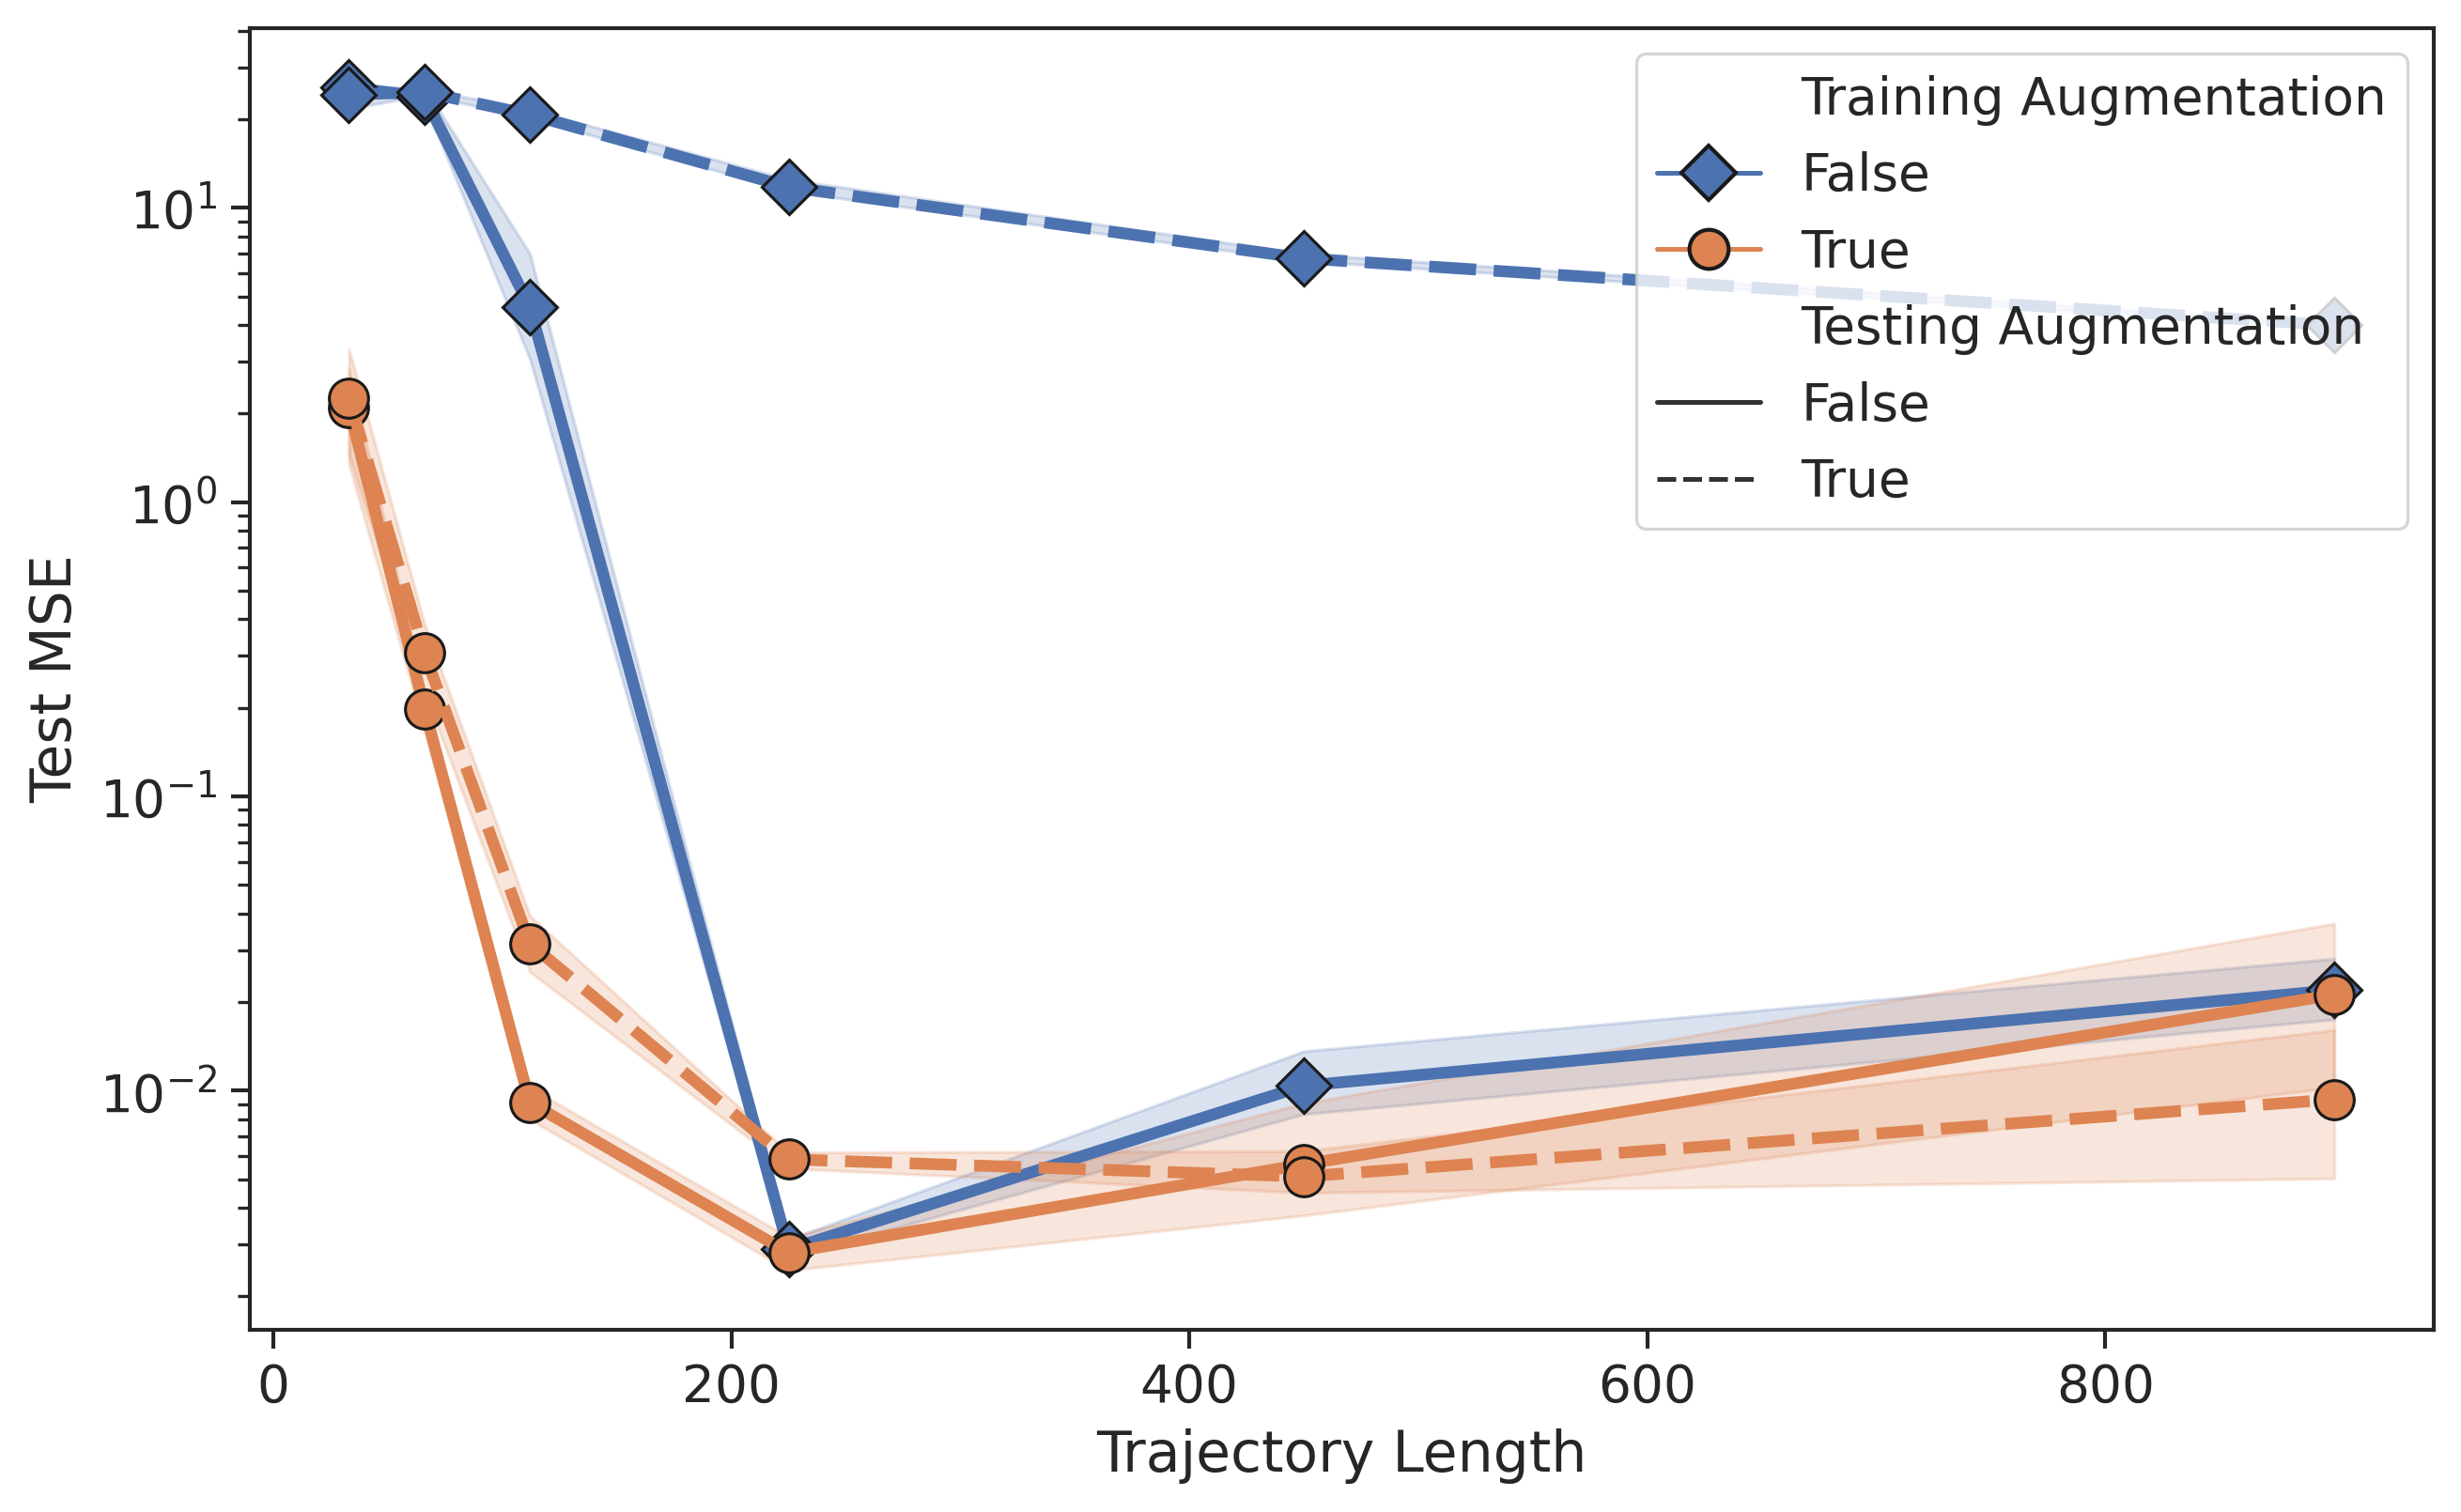

In [12]:
df = pd.read_csv("SAM_length_generalization_study.csv")

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
plot = sns.lineplot(
    data=df,
    x="traj_len",
    y="Loss",
    hue="Training Augmentation",
    style="Testing Augmentation",
    ax=ax,
    linewidth=3,
    markers=True,
    markeredgecolor="k",
)
fix_lineplot_markers(plot)
ax.set_yscale("log")
ax.set_xlabel("Trajectory Length")
ax.set_ylabel("Test MSE")
ax.legend(loc="upper right")
fig.savefig("SAM_trajectory_length_study.pdf", bbox_inches="tight")